In [2]:
print('Importing...')

%matplotlib inline

import glob
import os
import numpy as np
import time as systime
import re 
import textgrid as tg
import matplotlib.pyplot as plt
import matplotlib as matplotlib
import random as random 


from scipy.stats import multivariate_normal

from bokeh.plotting import show
from bokeh.io import output_notebook
from bokeh.plotting import figure
from bokeh.layouts import gridplot
from ipyparallel import Client
import _pickle as pickle

import sys

myseed = 6
np.random.seed(myseed)
random.seed(myseed)

print('success')

import subprocess
subprocess.Popen(["cd","../amdtk"]).communicate()
subprocess.Popen(["python", "setup.py", "install"]).communicate()
import amdtk


Importing...
success


Generates toy data from the exact prior distributions used to initialize the model.

The model should be able to learn this pretty much perfectly; if not, something is very wrong.

In [3]:
top_alphabet = [0,1,2,3]
print('success')

success


 let's have 1 more bottom level PLU



In [4]:
bot_alphabet = [0,1,2,3,4]
print('success')

success


Now we get some random sequences of top letters that represent a top alphabet.

Since the top level strings are a given input into the model, it doesn't actually matter what we generate here. So we're just 

In [57]:

top_strings = np.random.choice(top_alphabet, (100, 10))
print('success')

success


Now we define prob distributions over ins, sub, del, and sample edit operations for each top-level PLU

In [58]:
# Dirichlet parameters for distribution over edit ops for each of the top PLUs 
# (plus distribution over final insert bottoms)
# (insert_top prob) (insert_bottom probs) (sub probs)
ops_priors = [
    [1,1,2,1,1,1,3,2,1,1,1],
    [2,1,1,2,1,1,1,3,2,1,1],
    [3,1,1,1,2,1,1,1,3,1,1],
    [3,2,1,1,1,1,1,2,1,3,1],

]

# ops_priors = [
#     [1,.1,.1,.1,.1,.1,3,2,1,1,1],
#     [2,.1,.1,.1,.1,.1,1,3,2,1,1],
#     [3,.1,.1,.1,.1,.1,1,1,3,1,1],
#     [3,.1,.1,.1,.1,.1,1,2,1,3,1],
# ]

# Draw a sample from each Dirichlet to get the distribution
ops_dists = [np.random.dirichlet(i) for i in ops_priors]

# ins_top = [2]
# ins_bot = [.5,1,.5,4,2]
# sub = [[100, 3, 4, 1],
#       [.5, 100, 2, 2],
#       [2, .75, 100, 3],
#       [3,2,1,100]]


# full_dir = np.array(ins_top + ins_bot + sub[0] + sub[1] + sub[2] + sub[3], dtype=np.float64)
# # normalize 
# full_dir = full_dir/np.sum(full_dir)
# print(full_dir)

print('success')


success


In [59]:
bottom_strings = []
i = 0
while i < len(top_strings):
    ts = top_strings[i]
    j = 0
    bs = []
    while j < len(ts):
#         sample some edit operation
#         eo = np.argmax(np.random.multinomial(1, full_dir))
        eo = np.argmax(np.random.multinomial(1, ops_dists[ts[j]]))
#         print(ops_dists[ts[j]])
#         print(eo)
        if eo == 0:
#             insert top, do nothing
            j+=1
        elif eo >= 1 and eo <= 5:
            bc = bot_alphabet[eo-1]
            bs.append(bc)
        else:
#             sub
#             bc = bot_alphabet[(eo-5)%4]
            bc = bot_alphabet[(eo-6)] 
            bs.append(bc)
            j+=1
    i+=1
    print("num of top string PLUs: ", len(ts))
    print("num of bottom string PLUs: ", len(bs))
    print("\n")
    bottom_strings.append(bs)

print(bottom_strings)
print(len(bottom_strings[0]))



num of top string PLUs:  10
num of bottom string PLUs:  13


num of top string PLUs:  10
num of bottom string PLUs:  19


num of top string PLUs:  10
num of bottom string PLUs:  11


num of top string PLUs:  10
num of bottom string PLUs:  14


num of top string PLUs:  10
num of bottom string PLUs:  12


num of top string PLUs:  10
num of bottom string PLUs:  15


num of top string PLUs:  10
num of bottom string PLUs:  19


num of top string PLUs:  10
num of bottom string PLUs:  16


num of top string PLUs:  10
num of bottom string PLUs:  12


num of top string PLUs:  10
num of bottom string PLUs:  17


num of top string PLUs:  10
num of bottom string PLUs:  12


num of top string PLUs:  10
num of bottom string PLUs:  12


num of top string PLUs:  10
num of bottom string PLUs:  14


num of top string PLUs:  10
num of bottom string PLUs:  15


num of top string PLUs:  10
num of bottom string PLUs:  17


num of top string PLUs:  10
num of bottom string PLUs:  17


num of top string PLUs: 

Let's define the HMM/GMM parameters

In [60]:
# transition = [[.5, .5, 0],
#              [0, .5, .5],
#              [.75, 0, .25]]

components = []
# Distribution over components for each bottom PLU state
components.append([[.7,.3],
             [.9,.1],
             [.3,.7]])
components.append([[.3,.7],
             [.5,.5],
             [.8,.2]])
components.append([[.4,.6],
             [.2,.8],
             [.9,.1]])
components.append([[.5,.5],
             [.3,.7],
             [.6,.4]])
components.append([[.1,.9],
             [.6,.4],
             [.7,.3]])

x_vals = list(range(-30,30,2))
random.shuffle(x_vals)
y_vals = list(range(-30,30,2))
random.shuffle(y_vals)

random_means = [[x,y] for x,y in zip(x_vals,y_vals)]


# We need a set of parameters for each component
# for each HMM state for each bottom PLU
# So in this case, we need 2 * 3 * 5 = 30 sets of parameters
component_parameters = [
    [
        [
            [random_means[0], [[1,0],[0,1]]], # bottom PLU 0, HMM state 0, component 0
            [random_means[1], [[1,0],[0,1]]]  # bottom PLU 0, HMM state 0, component 1
        ],
        [
             [random_means[2], [[1,0],[0,1]]], # bottom PLU 0, HMM state 1, component 0
             [random_means[3], [[1,0],[0,1]]]  # bottom PLU 0, HMM state 1, component 1
        ],
        [
            [random_means[4], [[1,0],[0,1]]], # bottom PLU 0, HMM state 2, component 0
            [random_means[5], [[1,0],[0,1]]]  # bottom PLU 0, HMM state 2, component 1
        ]
    ],
    [
        [
            [random_means[6], [[1,0],[0,1]]], # bottom PLU 1, HMM state 0, component 0
            [random_means[7], [[1,0],[0,1]]]  # bottom PLU 1, HMM state 0, component 1
        ],
        [
             [random_means[8], [[1,0],[0,1]]], # bottom PLU 1, HMM state 1, component 0
             [random_means[9], [[1,0],[0,1]]]  # bottom PLU 1, HMM state 1, component 1
        ],
        [
            [random_means[10], [[1,0],[0,1]]], # bottom PLU 1, HMM state 2, component 0
            [random_means[11], [[1,0],[0,1]]]  # bottom PLU 1, HMM state 2, component 1
        ]
    ],
    [        
        [
            [random_means[12], [[1,0],[0,1]]], # bottom PLU 2, HMM state 0, component 0
            [random_means[13], [[1,0],[0,1]]]  # bottom PLU 2, HMM state 0, component 1
        ],
        [
             [random_means[14], [[1,0],[0,1]]], # bottom PLU 2, HMM state 1, component 0
             [random_means[15], [[1,0],[0,1]]]  # bottom PLU 2, HMM state 1, component 1
        ],
        [
            [random_means[16], [[1,0],[0,1]]], # bottom PLU 2, HMM state 2, component 0
            [random_means[17], [[1,0],[0,1]]]  # bottom PLU 2, HMM state 2, component 1
        ]
    ],
    [
        [
            [random_means[18], [[1,0],[0,1]]], # bottom PLU 3, HMM state 0, component 0
            [random_means[19], [[1,0],[0,1]]]  # bottom PLU 3, HMM state 0, component 1
        ],
        [
             [random_means[20], [[1,0],[0,1]]], # bottom PLU 3, HMM state 1, component 0
             [random_means[21], [[1,0],[0,1]]]  # bottom PLU 3, HMM state 1, component 1
        ],
        [
            [random_means[22], [[1,0],[0,1]]], # bottom PLU 3, HMM state 2, component 0
            [random_means[23], [[1,0],[0,1]]]  # bottom PLU 3, HMM state 2, component 1
        ]
    ],
    [
        [
            [random_means[24], [[1,0],[0,1]]], # bottom PLU 4, HMM state 0, component 0
            [random_means[25], [[1,0],[0,1]]]  # bottom PLU 4, HMM state 0, component 1
        ],
        [
             [random_means[26], [[1,0],[0,1]]], # bottom PLU 4, HMM state 1, component 0
             [random_means[27], [[1,0],[0,1]]]  # bottom PLU 4, HMM state 1, component 1
        ],
        [
            [random_means[28], [[1,0],[0,1]]], # bottom PLU 4, HMM state 2, component 0
            [random_means[29], [[1,0],[0,1]]]  # bottom PLU 4, HMM state 2, component 1
        ]
    ]


]

print('success')
# n1 = [[0,0], [[1,0],[0,1]]]
# n2 = [[10, 10], [[1,0],[0,1]]]


success


In [61]:
print('running...')

def sample_HMMGMM(bs):
    mfccs = []
    for i, char in enumerate(bs):
        vec = None
#         if i%10 == 0:
#             print("done with ", i)
#         start_state = np.random.choice([0,1,2], p=init)
        curr_state = 0
#       get the mfcc vector and transition
        while curr_state < 3:
            gmm_component_choice = np.random.choice(2,p=components[char][curr_state])
            vec = np.random.multivariate_normal(*component_parameters[char][curr_state][gmm_component_choice])
#             vec = components[curr_state][0]*np.random.multivariate_normal(*n1) + \
#                     components[curr_state][1]*np.random.multivariate_normal(*n2)
            
            mfccs.append(vec)
#             new_curr_state = np.random.choice([0,1,2], p=transition[curr_state])
            # Transition to next state with 50% probability
            curr_state = np.random.choice([curr_state,curr_state+1],p=[0.5,0.5])
#             if curr_state == 2 and new_curr_state == 0:
    #         get the mfcc vector and transition
#             curr_state = new_curr_state
    return np.array(mfccs)

all_data = []


for i, bs in enumerate(bottom_strings):
    print("num of bottom PLUs: ", len(bs))
    mfccs = sample_HMMGMM(bs)
    print("num of frames: ", mfccs.shape[0])
    print("frames per PLU: ", mfccs.shape[0]/float(len(bs)))
    
    all_data.append(mfccs)

print(all_data[0].shape)

print('success')
        
# for i,line in enumerate(all_data):
#     with open("/Users/esteng/ULD/audio/example_2d/sent_{}.fea", "w") as f1:
        
        

running...
num of bottom PLUs:  13
num of frames:  56
frames per PLU:  4.3076923076923075
num of bottom PLUs:  19
num of frames:  137
frames per PLU:  7.2105263157894735
num of bottom PLUs:  11
num of frames:  66
frames per PLU:  6.0
num of bottom PLUs:  14
num of frames:  92
frames per PLU:  6.571428571428571
num of bottom PLUs:  12
num of frames:  80
frames per PLU:  6.666666666666667
num of bottom PLUs:  15
num of frames:  73
frames per PLU:  4.866666666666666
num of bottom PLUs:  19
num of frames:  106
frames per PLU:  5.578947368421052
num of bottom PLUs:  16
num of frames:  103
frames per PLU:  6.4375
num of bottom PLUs:  12
num of frames:  76
frames per PLU:  6.333333333333333
num of bottom PLUs:  17
num of frames:  102
frames per PLU:  6.0
num of bottom PLUs:  12
num of frames:  56
frames per PLU:  4.666666666666667
num of bottom PLUs:  12
num of frames:  75
frames per PLU:  6.25
num of bottom PLUs:  14
num of frames:  82
frames per PLU:  5.857142857142857
num of bottom PLUs:  

In [62]:
def collect_data_stats(data):
    """Job to collect the statistics."""
    # We  re-import this module here because this code will run
    # remotely.
    
    stats_0 = data.shape[0]
    stats_1 = data.sum(axis=0)
    stats_2 = (data**2).sum(axis=0)
    retval = (
        stats_0,
        stats_1,
        stats_2
    )
    return retval

data_stats = list(map(collect_data_stats, all_data))

print('success')

success


In [63]:

def accumulate_stats(data_stats):
    n_frames = data_stats[0][0]
    mean = data_stats[0][1]
    var = data_stats[0][2]
    for stats_0, stats_1, stats_2 in data_stats[1:]:
        n_frames += stats_0
        mean += stats_1
        var += stats_2
    mean /= n_frames
    var = (var / n_frames) - mean**2

    data_stats = {
        'count': n_frames,
        'mean': mean,
        'var': var
    }
    return data_stats

final_data_stats = accumulate_stats(data_stats)

print('success')

success


In [64]:
print("Running...")

import subprocess
import amdtk
num_tops = 4

print("Finished imports in ipython notebook.")

print(len(all_data))
print(len(top_strings))
all_data_and_tops = list(zip(all_data, top_strings))
#print(all_data_and_tops[0])

elbo = []
time = []
def callback(args):
    elbo.append(args['lower_bound'])
    time.append(args['time'])
    print('elbo=' + str(elbo[-1]), 'time=' + str(time[-1]))
 

print("Creating phone loop model...")
conc = 0.1

n_units=5  # number of acoustic units
n_states=3   # number of states per unit
n_comp_per_state=3   # number of Gaussians per emission


model = amdtk.PhoneLoopNoisyChannel.create(
    n_units=n_units,  # number of acoustic units
    n_states=n_states,   # number of states per unit
    n_comp_per_state=n_comp_per_state,   # number of Gaussians per emission
    n_top_units=num_tops, # size of top PLU alphabet
    mean=np.zeros_like(final_data_stats['mean']), 
    var=np.ones_like(final_data_stats['var']),
    max_slip_factor=.05
    #concentration=conc
)


print("Creating VB optimizer...")   
optimizer = amdtk.ToyNoisyChannelOptimizer(
    dview, 
    final_data_stats, 
    args= {'epochs': 10,
     'batch_size': 100,
     'lrate': 0.01,
     'pkl_path': "example_test",
     'log_dir': 'logs'},
    model=model,
    dir_path="dir"
    
)

print("Running VB optimization...")
begin = systime.time()
print("running with toy data")
print('len(all_data_and_tops[0])')
print(len(all_data_and_tops[0]))
optimizer.run(all_data_and_tops, callback)
end = systime.time()
print("VB optimization took ",end-begin," seconds.")

# fig1 = figure(
#     x_axis_label='time (s)', 
#     y_axis_label='ELBO',
#     width=400, 
#     height=400
# )
# x = np.arange(0, len(elbo), 1)
# fig1.line(x, elbo)
#show(fig1)

print("\nDECODING\n")

date_string = systime.strftime("textgrids_%Y-%m-%d_%H:%M")

# Need to change this according to 
samples_per_sec = 100

all_data_and_tops = list(zip(all_data, top_strings))

for data, tops in all_data_and_tops:

    # Normalize the data
    data_mean = np.mean(data)
    data_var = np.var(data)
    data = (data-data_mean)/np.sqrt(data_var)

    #result = model.decode(data, tops, state_path=False)
    #result_path = model.decode(data, tops, state_path=True)
    (result_intervals, edit_path, plu_path) = model.decode(data, tops, phone_intervals=True, edit_ops=True)

    print("---")
    print("Phone sequence:")
    print(result_intervals)
    print(edit_path)
    

Running...
Finished imports in ipython notebook.
100
100
Creating phone loop model...
Creating VB optimizer...
Running VB optimization...
running with toy data
len(all_data_and_tops[0])
2
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end ite

log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>

log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>

log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>

log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>

  0.01980102  0.04603947]
posterior nat params:  [ 4.50706066  5.41240857  1.64195496  2.65104958  3.9355632   3.9355632
  3.9355632   3.9355632 ]
prior nat params:  [ 2.  2.  0.  0.  1.  1.  1.  1.]
posterior log partition:  -3.9124139123585104
prior log partition:  0.0
expected value:  [-1.90935474 -1.36835897 -0.86164708]
posterior nat params:  [ 0.22513019  0.79777045  1.68501372]
prior nat params:  [ 0.  0.  0.]
posterior log partition:  -4.038062604635036
prior log partition:  -0.6931471805599454
expected value:  [-1.45796773 -1.14268514 -1.15222579]
posterior nat params:  [ 1.13783381  1.76013233  1.73833604]
prior nat params:  [ 0.  0.  0.]
posterior log partition:  -6.787569526006871
prior log partition:  -0.6931471805599454
expected value:  [-1.05138829 -1.40384829 -1.30657221]
posterior nat params:  [ 1.94420313  1.20655974  1.38534   ]
prior nat params:  [ 0.  0.  0.]
posterior log partition:  -6.654589091373458
prior log partition:  -0.6931471805599454
expected value:  [-1

log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>

  4.06666161  4.06666161]
prior nat params:  [ 2.  2.  0.  0.  1.  1.  1.  1.]
posterior log partition:  -3.774044577988643
prior log partition:  0.0
expected value:  [-0.65941856 -0.75586239  0.2185594   0.68104338 -0.08862767 -0.22392528
  0.07404254  0.14229297]
posterior nat params:  [ 6.32923747  6.7908305   1.17503342  3.19428697  7.09041875  7.09041875
  7.09041875  7.09041875]
prior nat params:  [ 2.  2.  0.  0.  1.  1.  1.  1.]
posterior log partition:  -6.776499891715025
prior log partition:  0.0
expected value:  [-0.64636202 -0.79604077 -0.97060046 -1.06700422 -0.41061264 -0.40379064
  0.08485874  0.18900407]
posterior nat params:  [ 15.23370107  12.27665681  -8.11862078  -7.24683568  10.81303439
  10.81303439  10.81303439  10.81303439]
prior nat params:  [ 2.  2.  0.  0.  1.  1.  1.  1.]
posterior log partition:  -9.840486933118395
prior log partition:  0.0
expected value:  [-0.52202705 -0.52585521 -0.56457428  0.45429562 -0.29307293 -0.23854412
 -0.09594995 -0.09229669]
po

log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>

  3.54185232  3.54185232]
prior nat params:  [ 2.  2.  0.  0.  1.  1.  1.  1.]
posterior log partition:  -4.427954485767337
prior log partition:  0.0
expected value:  [-0.62077994 -0.52776795 -1.1080467  -0.39148604 -0.6414752  -0.21962848
 -0.01387773 -0.09503771]
posterior nat params:  [ 6.25307823  4.63692838 -3.03497733 -1.26127078  3.40067442  3.40067442
  3.40067442  3.40067442]
prior nat params:  [ 2.  2.  0.  0.  1.  1.  1.  1.]
posterior log partition:  -3.9051213917171737
prior log partition:  0.0
expected value:  [-0.65469111 -0.68944068  0.5550732   0.94748942 -0.24046932 -0.44834664
  0.02979372  0.05565228]
posterior nat params:  [ 4.60453289  5.59996308  1.72583302  2.7974506   4.07112988  4.07112988
  4.07112988  4.07112988]
prior nat params:  [ 2.  2.  0.  0.  1.  1.  1.  1.]
posterior log partition:  -4.004102633637753
prior log partition:  0.0
expected value:  [-1.90687237 -1.37047206 -0.86389308]
posterior nat params:  [ 0.22150793  0.78554382  1.66467558]
prior nat

log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>

posterior nat params:  [ 30.35946511  27.78502777 -17.23773207 -19.37920438  24.60668057
  24.60668057  24.60668057  24.60668057]
prior nat params:  [ 2.  2.  0.  0.  1.  1.  1.  1.]
posterior log partition:  -16.037645986516917
prior log partition:  0.0
expected value:  [-1.0479578  -1.17562872  1.09593862 -0.14325695 -0.30474335 -0.02257845
  0.35221536  0.40969525]
posterior nat params:  [ 21.08004008  12.20222817  14.35391174  -1.67252779  27.45097856
  27.45097856  27.45097856  27.45097856]
prior nat params:  [ 2.  2.  0.  0.  1.  1.  1.  1.]
posterior log partition:  -9.88001184068188
prior log partition:  0.0
expected value:  [-0.74821915 -0.75017492  1.62693089 -0.10464571 -0.9887734  -0.10802144
  0.11028208  0.11158732]
posterior nat params:  [ 9.53203345  3.88277419  5.20830088 -0.33412937  4.79055442  4.79055442
  4.79055442  4.79055442]
prior nat params:  [ 2.  2.  0.  0.  1.  1.  1.  1.]
posterior log partition:  -4.1834010145685125
prior log partition:  0.0
expected valu

log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>

 -0.06572855  0.06083207]
posterior nat params:  [ 3.94552608  5.89163683  0.96235911  3.10378264  3.15172283  3.15172283
  3.15172283  3.15172283]
prior nat params:  [ 2.  2.  0.  0.  1.  1.  1.  1.]
posterior log partition:  -3.05420346531658
prior log partition:  0.0
expected value:  [-0.54025704 -0.52311861 -0.34113554 -0.10366159 -0.19501407 -0.14629852
 -0.07929966 -0.09541806]
posterior nat params:  [ 4.5566112   4.37604524 -1.1182666  -0.35094296  3.54200208  3.54200208
  3.54200208  3.54200208]
prior nat params:  [ 2.  2.  0.  0.  1.  1.  1.  1.]
posterior log partition:  -4.437591028604816
prior log partition:  0.0
expected value:  [-0.61845909 -0.52600348 -1.0980536  -0.38992055 -0.63450959 -0.2193811
 -0.01581246 -0.09677406]
posterior nat params:  [ 6.2344052   4.64802261 -3.01703533 -1.25966578  3.39858258  3.39858258
  3.39858258  3.39858258]
prior nat params:  [ 2.  2.  0.  0.  1.  1.  1.  1.]
posterior log partition:  -3.9177890835232043
prior log partition:  0.0
expec

log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>
log op counts are:  <class 'list'>
end item total is <class 'numpy.float64'>

---
Phone sequence:
[(2, 0, 4), (1, 4, 9), (2, 9, 14), (3, 14, 18), (1, 18, 24), (2, 24, 31), (1, 31, 38), (3, 38, 44), (2, 44, 52), (1, 52, 56)]
[('SUB', 1, 2), ('SUB', 3, 1), ('SUB', 1, 2), ('SUB', 1, 3), ('SUB', 3, 1), ('SUB', 2, 2), ('SUB', 1, 1), ('SUB', 3, 3), ('SUB', 3, 2), ('SUB', 1, 1)]
---
Phone sequence:
[(2, 0, 4), (1, 4, 17), (2, 17, 28), (1, 28, 43), (2, 43, 63), (1, 63, 84), (2, 84, 92), (1, 92, 104), (3, 104, 113), (2, 113, 134), (3, 134, 137)]
[('IB', 1, 2), ('SUB', 2, 1), ('SUB', 1, 2), ('SUB', 3, 1), ('SUB', 0, 2), ('SUB', 0, 1), ('SUB', 0, 2), ('SUB', 3, 1), ('SUB', 1, 3), ('SUB', 2, 2), ('SUB', 1, 3)]
---
Phone sequence:
[(3, 0, 7), (1, 7, 11), (2, 11, 16), (1, 16, 23), (2, 23, 32), (1, 32, 38), (2, 38, 47), (1, 47, 52), (2, 52, 60), (1, 60, 66)]
[('SUB', 0, 3), ('SUB', 1, 1), ('SUB', 3, 2), ('SUB', 0, 1), ('SUB', 2, 2), ('SUB', 3, 1), ('SUB', 1, 2), ('SUB', 1, 1), ('SUB', 2, 2), ('SUB', 2, 1)]
---
Phone sequence:
[(2, 0, 4), (1, 4, 15), (2, 15, 24), (3, 24, 40), (

---
Phone sequence:
[(2, 0, 5), (1, 5, 14), (2, 14, 22), (1, 22, 30), (2, 30, 42), (1, 42, 51), (3, 51, 60), (1, 60, 72), (2, 72, 82), (1, 82, 91), (2, 91, 96)]
[('SUB', 3, 2), ('IB', 3, 1), ('SUB', 2, 2), ('SUB', 2, 1), ('SUB', 0, 2), ('SUB', 0, 1), ('SUB', 1, 3), ('SUB', 2, 1), ('SUB', 2, 2), ('SUB', 1, 1), ('SUB', 0, 2)]
---
Phone sequence:
[(3, 0, 3), (1, 3, 7), (2, 7, 15), (3, 15, 22), (2, 22, 31), (3, 31, 37), (1, 37, 48), (2, 48, 52), (1, 52, 58), (2, 58, 68)]
[('SUB', 1, 3), ('SUB', 1, 1), ('SUB', 2, 2), ('SUB', 3, 3), ('SUB', 2, 2), ('SUB', 1, 3), ('SUB', 2, 1), ('SUB', 2, 2), ('SUB', 2, 1), ('SUB', 0, 2)]
---
Phone sequence:
[(2, 0, 6), (1, 6, 9), (2, 9, 18), (1, 18, 25), (2, 25, 36), (1, 36, 43), (2, 43, 50), (1, 50, 57), (2, 57, 67), (1, 67, 73), (2, 73, 79)]
[('IB', 3, 2), ('SUB', 1, 1), ('SUB', 1, 2), ('SUB', 2, 1), ('SUB', 2, 2), ('SUB', 3, 1), ('SUB', 3, 2), ('SUB', 3, 1), ('SUB', 3, 2), ('SUB', 1, 1), ('SUB', 3, 2)]
---
Phone sequence:
[(3, 0, 5), (2, 5, 18), (3, 18, 2

---
Phone sequence:
[(1, 0, 4), (2, 4, 15), (1, 15, 22), (3, 22, 28), (2, 28, 39), (1, 39, 47), (2, 47, 59), (1, 59, 65), (2, 65, 72), (1, 72, 83)]
[('SUB', 3, 1), ('SUB', 2, 2), ('SUB', 2, 1), ('SUB', 1, 3), ('SUB', 1, 2), ('SUB', 3, 1), ('SUB', 3, 2), ('SUB', 3, 1), ('SUB', 1, 2), ('SUB', 2, 1)]
---
Phone sequence:
[(1, 0, 4), (2, 4, 23), (1, 23, 38), (2, 38, 55), (1, 55, 80), (3, 80, 86), (2, 86, 106), (1, 106, 119), (2, 119, 136), (1, 136, 155), (2, 155, 164)]
[('SUB', 2, 1), ('IB', 2, 2), ('SUB', 0, 1), ('SUB', 0, 2), ('SUB', 1, 1), ('SUB', 0, 3), ('SUB', 3, 2), ('SUB', 0, 1), ('SUB', 2, 2), ('SUB', 0, 1), ('SUB', 1, 2)]
---
Phone sequence:
[(2, 0, 10), (1, 10, 16), (2, 16, 26), (1, 26, 33), (3, 33, 41), (2, 41, 57), (1, 57, 65), (2, 65, 74), (1, 74, 81), (2, 81, 98)]
[('SUB', 3, 2), ('SUB', 3, 1), ('SUB', 0, 2), ('SUB', 0, 1), ('SUB', 3, 3), ('SUB', 3, 2), ('SUB', 1, 1), ('SUB', 2, 2), ('SUB', 2, 1), ('SUB', 0, 2)]
---
Phone sequence:
[(2, 0, 5), (1, 5, 18), (2, 18, 34), (1, 34, 

---
Phone sequence:
[(2, 0, 11), (1, 11, 18), (2, 18, 33), (1, 33, 42), (2, 42, 58), (1, 58, 70), (2, 70, 84), (1, 84, 99), (2, 99, 118), (1, 118, 126), (2, 126, 132)]
[('IB', 0, 2), ('SUB', 1, 1), ('SUB', 1, 2), ('SUB', 1, 1), ('SUB', 1, 2), ('SUB', 1, 1), ('SUB', 1, 2), ('SUB', 2, 1), ('SUB', 2, 2), ('SUB', 1, 1), ('SUB', 0, 2)]
---
Phone sequence:
[(2, 0, 6), (1, 6, 13), (2, 13, 20), (3, 20, 24), (1, 24, 31), (2, 31, 35), (1, 35, 42), (2, 42, 51), (1, 51, 56), (2, 56, 65)]
[('SUB', 3, 2), ('SUB', 1, 1), ('SUB', 1, 2), ('SUB', 3, 3), ('SUB', 1, 1), ('SUB', 1, 2), ('SUB', 1, 1), ('SUB', 2, 2), ('SUB', 1, 1), ('SUB', 2, 2)]
---
Phone sequence:
[(2, 0, 9), (1, 9, 13), (2, 13, 20), (1, 20, 30), (2, 30, 42), (1, 42, 51), (2, 51, 60), (1, 60, 74), (2, 74, 89), (3, 89, 94)]
[('SUB', 0, 2), ('SUB', 3, 1), ('SUB', 2, 2), ('SUB', 1, 1), ('SUB', 1, 2), ('SUB', 1, 1), ('SUB', 0, 2), ('SUB', 0, 1), ('SUB', 2, 2), ('SUB', 1, 3)]
---
Phone sequence:
[(3, 0, 3), (1, 3, 10), (2, 10, 24), (1, 24, 28),

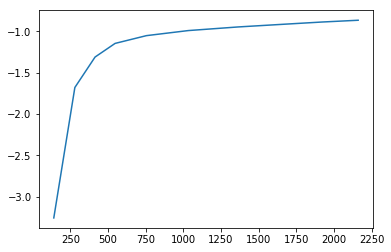

In [65]:
plt.plot(time, elbo)


In [66]:
component_parameters_flat1 = []
_ = [component_parameters_flat1.extend(x) for x in component_parameters]
component_parameters_flat = []
_ = [component_parameters_flat.extend(x) for x in component_parameters_flat1]

learned_components = model.components
learned_posteriors = [comp.posterior for comp in learned_components]
dimensionality = all_data[0].shape[1]
learned_natural_params = [post.natural_params.reshape((-1,dimensionality)) for post in learned_posteriors]

learned_means = [ n[1]/n[2] for n in learned_natural_params ]
learned_vars = [ (n[0]-((n[1]**2)/n[2]))/(n[3]+1) for n in learned_natural_params ]
learned_means = learned_means * np.sqrt(final_data_stats['var']) + final_data_stats['mean']
learned_vars = learned_vars * np.sqrt(final_data_stats['var'])
# print(learned_means)



30
54
45
54
[[ 19.54736617  20.38329671]
 [ 15.53005985  17.83935483]
 [ 14.40382348  15.15670727]
 [ 16.00113066  18.15039036]
 [ 14.8935304   15.64810423]
 [ 13.5946486   15.08696785]
 [ 12.15013243  14.47118172]
 [ 15.96508851  17.10543047]
 [ 14.7397092   15.77647277]
 [  9.15458646   7.68476016]
 [ 11.46539565  10.80519413]
 [  7.17224797   4.02588748]
 [  9.19352777  14.9369724 ]
 [  9.04682947   5.11862256]
 [  6.36586218   4.97057385]
 [ 13.04978873  10.91531644]
 [ 13.85217412   9.96612248]
 [  8.35277318   9.29462266]
 [ 11.38284444  13.84661556]
 [  9.71243285  11.19804648]
 [  7.24124015   8.7248495 ]
 [  6.38447507   8.03906103]
 [  7.3922868    9.05590178]
 [  5.97820585   3.95751522]
 [  3.56146177   4.14061193]
 [ 11.74012175   8.93284438]
 [  7.26813136   6.90866586]
 [ 10.34919968  11.36096456]
 [ 12.06980063  10.73670125]
 [ 12.36086023  10.37359072]
 [ 16.17455792  16.57698948]
 [ 11.60329281   9.80913248]
 [ 15.67393988  11.43897642]
 [ 11.03137704  11.04995078]
 [

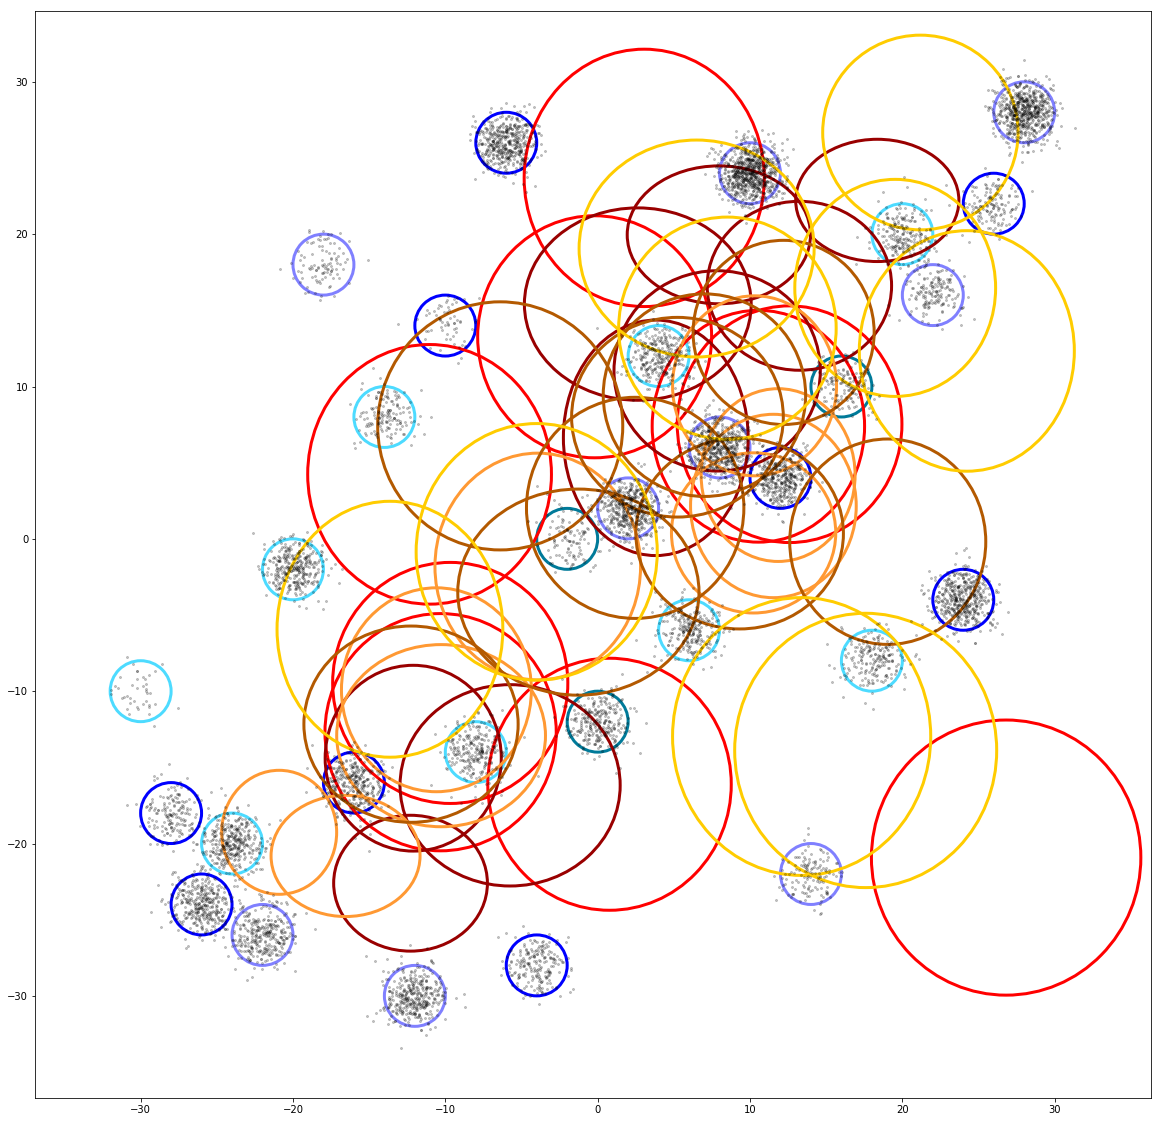

In [67]:


def gaussian_2d(x, y, dist):
    return dist.pdf([x,y])

gaussian_2d_v = np.vectorize(gaussian_2d)

# Based on code from joferkington at 
# https://github.com/joferkington/oost_paper_code/blob/master/error_ellipse.py
def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = matplotlib.patches.Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip

# if __name__ == '__main__':
#     #-- Example usage -----------------------
#     # Generate some random, correlated data
#     points = np.random.multivariate_normal(
#             mean=(1,1), cov=[[0.4, 9],[9, 10]], size=1000
#             )
#     # Plot the raw points...
#     x, y = points.T
#     plt.plot(x, y, 'ro')

#     # Plot a transparent 3 standard deviation covariance ellipse
#     plot_point_cov(cov=cov, mean=mean, nstd=2, alpha=0.5, color='green')

#     plt.show()


def plot_gauss_2d(mean, cov, xlim=(-2.0, 2.0), ylim=(-2.0, 2.0), color='k'):
#     mv = multivariate_normal(mean=mean, cov=cov)
    plot_cov_ellipse(cov=cov, pos=mean, nstd=2, fill=False, lw=3, color=color)
#     x = np.linspace(*xlim)
#     y = np.linspace(*ylim)
#     X, Y = np.meshgrid(x, y)
#     Z = gaussian_2d_v(X, Y, mv)
#     CS = plt.contour(X, Y, Z, 2, colors=colors)
    #fmt = {CS.levels[0]: '95%', CS.levels[1]: '99%'}
    #plt.clabel(CS, fmt=fmt)
    
plt.figure(figsize=(20, 20))
plt.axis('equal')
xlim = (-100, 100)
ylim = (-100, 100)
# plot_gauss_2d(mean=[0,1], cov=[[1,0.5],[0.5,1]])
# plot_gauss_2d(mean=[1,0], cov=[[1,-0.5],[-0.5,1]])

component_parameters

def list_repeat(given_list, repeat_factor):
    return_list = []
    for item in given_list:
        return_list.extend([item]*repeat_factor)
    return return_list


colors_given_list = ['#0000ff', '#8080ff', '#4ddbff', '#007a99', '#00cc00', '#008000']
colors_learned_list = ['#ff0000', '#990000', '#ff9933', '#b35900', '#ffcc00', '#ff6633']


colors_given = list_repeat(colors_given_list, n_states*n_comp_per_state)
colors_learned = list_repeat(colors_learned_list, n_states*n_comp_per_state)


print(len(component_parameters_flat))
print(len(colors_given))
print(len(learned_means))
print(len(colors_learned))
print(learned_vars)



# Plot gaussians used to generate data
_ = [ plot_gauss_2d(mean=comp[0], cov=comp[1], xlim=xlim, ylim=ylim, color=color) for comp, color in zip(component_parameters_flat, colors_given)]

# Plot gaussians learned from data
_ = [ plot_gauss_2d(mean=mean, cov=[[var[0],0],[0,var[1]]], xlim=xlim, ylim=ylim, color=color) for mean, var, color in zip(learned_means, learned_vars, colors_learned)]

# Plot data
for mfccs in all_data:
    plt.plot(mfccs[:,0], mfccs[:,1], color='#00000033', marker='o',  linestyle='none', markersize=2)
   

In [68]:
print(learned_means)

[[ 26.81297819 -20.92245913]
 [  3.05706355  23.69432115]
 [-10.30938463 -12.69204657]
 [-11.03361851   4.23466695]
 [ -9.67720215  -9.45815995]
 [ 12.59852517   7.52493028]
 [ 10.54958072   7.39181669]
 [  0.77818904 -16.10888396]
 [ -0.19795773  13.26414516]
 [ 13.24235427  16.6115292 ]
 [  7.84417304  11.02506362]
 [ 18.35583252  22.21557009]
 [  3.81467858   6.63184142]
 [  7.95549     19.95598016]
 [-12.28329951 -22.60431585]
 [ -5.74682787 -16.17936383]
 [  2.63422082  15.41066097]
 [-12.1069462  -14.39862199]
 [ -3.93237054  -1.81705592]
 [-10.58433423  -9.90666003]
 [ 10.29922972  10.0455078 ]
 [ 11.84502112   4.18652494]
 [ 11.53548353   2.15704739]
 [-16.54892196 -20.81423866]
 [-20.9073428  -19.26336074]
 [-10.27787073 -12.91952411]
 [ 10.2363383    0.3898434 ]
 [ 19.04252668  -0.18753798]
 [  5.23862066   7.98395592]
 [-12.251841   -12.16573454]
 [ -6.39654979   7.41557105]
 [  9.31953218   0.34941381]
 [ -1.265571    -3.49757947]
 [  7.00885925   9.43117496]
 [ 12.20640495